In [1]:
# setup disply parameters
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
%pylab inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%config InlineBackend.figure_formats = ['retina', 'pdf', 'png']

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
pylab.rcParams['figure.figsize'] = (18, 6)

Populating the interactive namespace from numpy and matplotlib


/Users/yasser/code/projects/negmas/venv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Running a Negotiation

NegMAS has several built-in negotiation `Mechanism` s (`Protocol` s), negotiation agents (`Negotiator` s), and `UtilityFunction` s. You can use these to run negotiations as follows:

In [2]:
import random # for generating random ufuns
random.seed(0) # for reproducibility
from pprint import pprint # for printing
from negmas import SAOMechanism, AspirationNegotiator, MappingUtilityFunction

session = SAOMechanism(outcomes=10, n_steps=100)
negotiators = [AspirationNegotiator(name=f'a{_}') for _ in range(5)]
for negotiator in negotiators:
    session.add(negotiator, ufun=MappingUtilityFunction(lambda x: random.random() * x[0]))

pprint(session.run().__dict__)

{'agreement': (4,),
 'broken': False,
 'current_offer': (4,),
 'current_offerer': 'a0-656a4272-3a2f-4ed5-8c25-1955d9b765ae',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 5,
 'n_negotiators': 5,
 'relative_time': 0.06,
 'running': False,
 'started': True,
 'step': 5,
 'time': 0.0012760839999828022,
 'timedout': False}


Negotations end with a status that shows you what happens. In the above example, we can see that the negotiation was not broken and did not time-out. The agreement was on outcome `(4,)` of the *10* possible outcomes of this negotiation. That offer was offered by negotiator `a0` (the rest of the agent *ID* is always a random value to ensure no name repetitions) which was accepted by all of the other *4* negotiators.

It is possible to run the same negotiation using a `Protocol` object instead of a `Mechanism` object

In [3]:
random.seed(0) # for reproducibility
from negmas import SAOProtocol

session = SAOProtocol(outcomes=10, n_steps=100)
negotiators = [AspirationNegotiator(name=f'a{_}') for _ in range(5)]
for negotiator in negotiators:
    session.add(negotiator, ufun=MappingUtilityFunction(lambda x: random.random() * x[0]))

pprint(session.run().__dict__)

{'agreement': (4,),
 'broken': False,
 'current_offer': (4,),
 'current_offerer': 'a0-e5d2fe63-4a22-434a-9b91-5332b56e6227',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 5,
 'n_negotiators': 5,
 'relative_time': 0.06,
 'running': False,
 'started': True,
 'step': 5,
 'time': 0.0022166910000578355,
 'timedout': False}


As you can see, we got the same output.`Protocol` is an alias of `Mechanism` in NegMAS.

Let's try a more meaningful situation:
Assume we have a buyer and a seller who are negotiating about a business transaction in which the buyer wants to maximize his profit while the seller wants to minimize her cost. They both would like to transact on as much as possible of the product and each has some preferred delivery time.

This can be modeled in the following negotiation:


In [4]:
from negmas import Issue, SAOMechanism, AspirationNegotiator, normalize
from negmas.utilities import LinearUtilityAggregationFunction as LUFun
issues = [Issue(name='price', values=10), Issue(name='quantity', values=10)
          , Issue(name='delivery_time', values=10)]
session = SAOMechanism(issues=issues, n_steps=20)

buyer_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: 9.0 - x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: x})
                         , outcomes=session.outcomes)

seller_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: 9.0 - x})
                           , outcomes=session.outcomes)


session.add(AspirationNegotiator(name='buyer'), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller'), ufun=seller_utility)
pprint(session.run().__dict__)

{'agreement': {'delivery_time': 8, 'price': 9, 'quantity': 6},
 'broken': False,
 'current_offer': {'delivery_time': 8, 'price': 9, 'quantity': 6},
 'current_offerer': 'seller-cd14dd98-7a77-4c24-985a-58c0c9ce0974',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 2,
 'n_negotiators': 2,
 'relative_time': 0.9,
 'running': False,
 'started': True,
 'step': 17,
 'time': 0.03735982100010915,
 'timedout': False}


In this run, we can see that the agreement was on a high price (*9*) which is preferred by the seller but with a delivery time of *8* which is preferred by the buyer. Negotiation took *17* steps out of the allowed *20* (*90%* of the available time)


We can check the negotiation history as well


In [5]:
for i, _ in enumerate(session.history):
    print(f'{i:03}: {_.current_offerer} offered {_.current_offer}')

000: buyer-1e94717d-6159-496c-b41c-30dc4911447f offered {'price': 0, 'quantity': 5, 'delivery_time': 9}
001: seller-cd14dd98-7a77-4c24-985a-58c0c9ce0974 offered {'price': 9, 'quantity': 5, 'delivery_time': 0}
002: buyer-1e94717d-6159-496c-b41c-30dc4911447f offered {'price': 0, 'quantity': 5, 'delivery_time': 9}
003: seller-cd14dd98-7a77-4c24-985a-58c0c9ce0974 offered {'price': 9, 'quantity': 9, 'delivery_time': 1}
004: buyer-1e94717d-6159-496c-b41c-30dc4911447f offered {'price': 1, 'quantity': 9, 'delivery_time': 9}
005: seller-cd14dd98-7a77-4c24-985a-58c0c9ce0974 offered {'price': 9, 'quantity': 9, 'delivery_time': 1}
006: buyer-1e94717d-6159-496c-b41c-30dc4911447f offered {'price': 1, 'quantity': 8, 'delivery_time': 9}
007: seller-cd14dd98-7a77-4c24-985a-58c0c9ce0974 offered {'price': 9, 'quantity': 7, 'delivery_time': 1}
008: buyer-1e94717d-6159-496c-b41c-30dc4911447f offered {'price': 1, 'quantity': 6, 'delivery_time': 9}
009: seller-cd14dd98-7a77-4c24-985a-58c0c9ce0974 offered {'p

We can even plot the complete negotiation history and visually see how far were the result from the pareto frontier (it was 0.043 utility units far from it). We can see that it was possible to increase the utility of the seller without decreasing the utility of the buyer at the agreement point (i.e. going vertically up from the agreement). That means that there is some *money left on the table* yet the results are not very far from the pareto front.

/Users/yasser/code/projects/negmas/venv/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


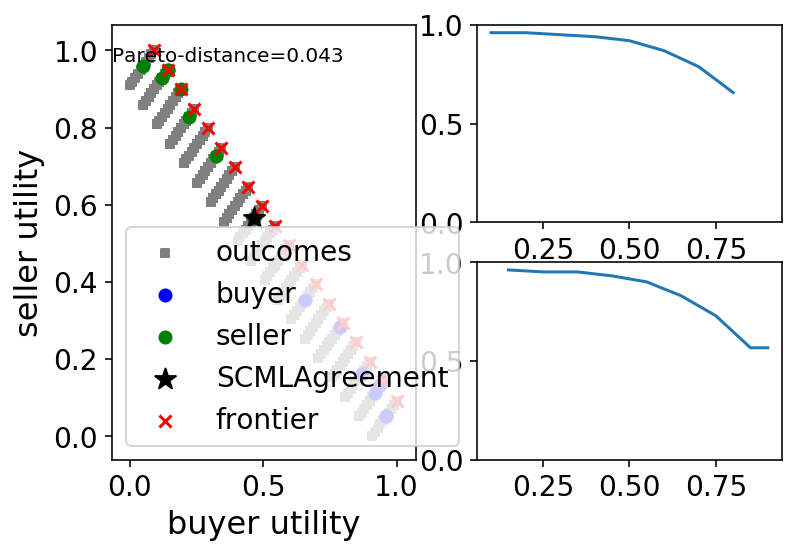

In [6]:
session.plot(plot_outcomes=False)

What happens if the seller was much more interested in delivery time. 

Firstly, what do you expect? 

Given that delivery time becomes a more important issue now, the buyer will get more utility points by allowing the price to go up given that the delivery time can be made earlier. This means that we should expect the delivery time to go down in the agreement and the price to go up if it can. Let's see what happens:

In [7]:
session = SAOMechanism(issues=issues, n_steps=50)

buyer_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: 9.0 - x}
                                     , weights = {'price': 1.0, 'quantity': 1.0, 'delivery_time': 10.0})
                         , outcomes=session.outcomes)

session.add(AspirationNegotiator(name='buyer'), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller'), ufun=seller_utility)
pprint(session.run().__dict__)

{'agreement': {'delivery_time': 0, 'price': 9, 'quantity': 5},
 'broken': False,
 'current_offer': {'delivery_time': 0, 'price': 9, 'quantity': 5},
 'current_offerer': 'seller-647221d4-1363-4459-9a1e-3da6ea682631',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 2,
 'n_negotiators': 2,
 'relative_time': 0.08,
 'running': False,
 'started': True,
 'step': 3,
 'time': 0.07148788400013473,
 'timedout': False}


We can check it visually as well:

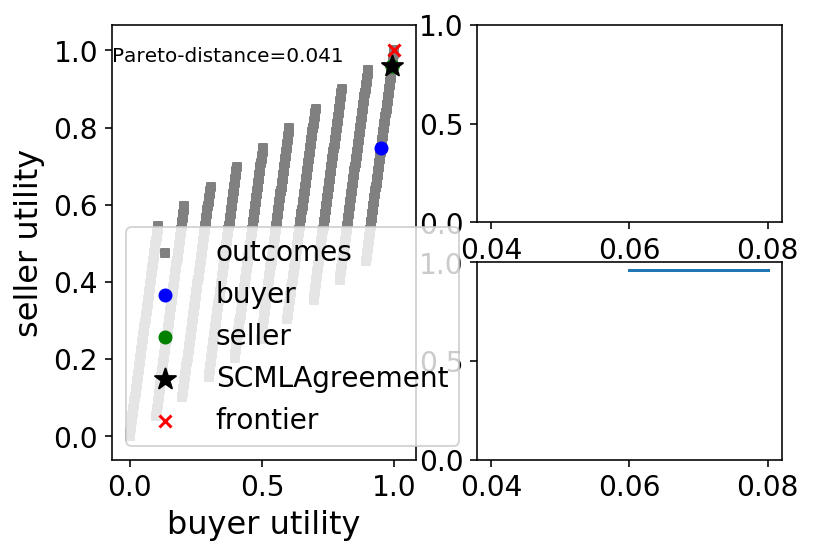

In [8]:
session.plot(plot_outcomes=False)

It is clear that the new ufuns transformed the problem. Now we have a single outcome at the pareto front. The agreement again is near to it (*0.041* utility points) and as expected the agreement was to make the delivery time *0* which is much earlier than before. Moreover, the negotation eas much faster finighing in 3 steps (8% of the available time).

What happens if we repeat the earlier neotiation but with a much longer negotiation time:


{'agreement': {'delivery_time': 9, 'price': 9, 'quantity': 9},
 'broken': False,
 'current_offer': {'delivery_time': 9, 'price': 9, 'quantity': 9},
 'current_offerer': 'seller-2b0e127a-6617-4295-a9b5-0d630c090042',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 2,
 'n_negotiators': 2,
 'relative_time': 0.809,
 'running': False,
 'started': True,
 'step': 1617,
 'time': 0.40377911500013397,
 'timedout': False}


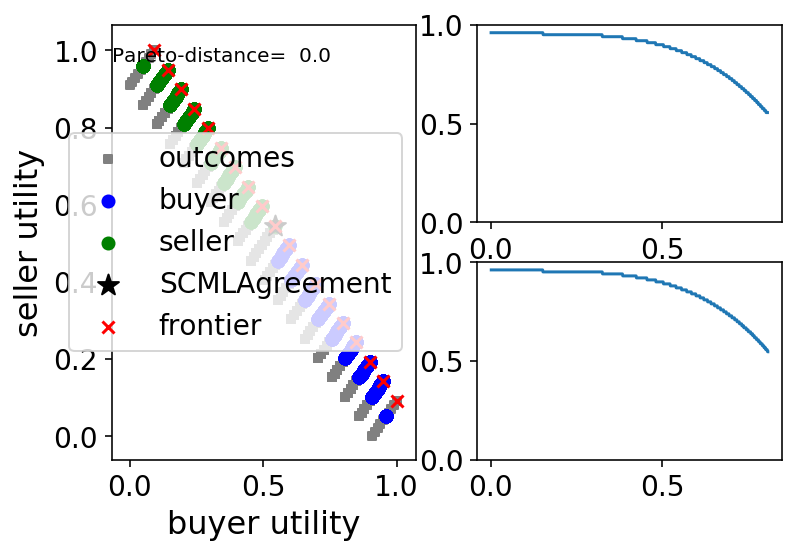

In [9]:
session = SAOMechanism(issues=issues, n_steps=2000)

buyer_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: 9.0 - x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: x})
                         , outcomes=session.outcomes)

seller_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: 9.0 - x})
                           , outcomes=session.outcomes)


session.add(AspirationNegotiator(name='buyer'), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller'), ufun=seller_utility)

pprint(session.run().__dict__)
session.plot(plot_outcomes=False)

Given the longer negotiation time, the buyer and the seller can both take a tougher stance conceding as slowly as possible and as a result the actually acheive a point exatly on the pareto-front. Moreover, this point happens to maximze the *welfare* defined as the sum of the utility received by both partners.
